In [7]:
import numpy as np
import math
from p import Pages
import matplotlib.pyplot as plt


In [141]:

def get_B(R, A, B, G, P):
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    # Update output, if needed
    for k in range(len(A)):
        
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k

            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d
            Bout = float(B[k]) + float(G[k])*h
            break
 
    return Bout



def rot_matrix(alpha):
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]]) # Defining the rotation matrix in a clockwise direction
    return R


def next_point(r, P, D):
    
    s = 0.001 # Step size

   
    pc = np.matmul(rot_matrix(-math.pi/2), D) # Multiplying the two matrices together to get the vector going from the point to the center
    pc = r *pc 

    Cx = P[0]+pc[0]
    Cy = P[1]+pc[1]
    c = np.array([Cx, Cy])
   
    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/r
  
    CP2 = np.matmul(rot_matrix(-theta), CP)
    P2 = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    PC2 = -CP2
    D2 = np.matmul(rot_matrix(math.pi/2), PC2)

    # Compute the magnitude of the vector
    magnitude = np.linalg.norm(D2) 
    # Normalize the vector
    D2 = D2/magnitude  


    return P2, D2   




def get_points(R, A, B, G, P, D, Energy, size):

    # Compute the magnitude of the vector for normalization
    magnitude = np.linalg.norm(D) 
    # Normalize the vector
    eps = 1e-10
    D = D/(magnitude+eps) # Normalizing the vector and adding a tiny constant to avoid division by zero error

    B_e = 3.3356*(Energy/1000) # Beam Rigidity
    s = 0.01 # Step size

    points = []
    points.append([float(P[0]), float(P[1])])

    directions = []

    trajectory_len = float(size)
    num_steps = trajectory_len/s

    for i in range(int(num_steps)):

        Bout = get_B(R, A, B, G, P)
        if Bout != 0:
            bending_rad = B_e/Bout # Radius
            P, D = next_point(bending_rad,P,D) # Calculating the next point
        else: # If the magnetic field is zero at this point the particle just continues in a straight line
            P2 = s*D
            P = np.add(P, P2)

        points.append(P)
        directions.append(D)
     
    # Splitting the data into x and y coordinates for plotting
    x = [point[0] for point in points]
    y = [point[1] for point in points]


    return x,y,directions



In [155]:



def default2(A, li, R):
    """ This function creates the default preview that the user can see without having to input X_min, X_max, Y_min, Y_max"""


    # Default values for x_min, x_max, y_min, y_max
    X_min = -0.2
    X_max = R + 0.5
    Y_min = -R-0.2
    Y_max = 0.2
    a = 0 # X coordinate of center of circle
    b = -R # Y coordinate of center of circle
    stepSize = 0.001 # Stepsize of line of circle

    # This is to calculate the coordinates of the circles circumference
    positions = []
    t = 0
    while t < 2 * math.pi:
        positions.append((R*math.cos(t) + a, R*math.sin(t) + b))
        t += stepSize
    X = []
    Y = []
    for i in positions:
        x, y = i
        X.append(x)
        Y.append(y)

    # Initiating the plot
    fig, ax = plt.subplots(figsize=(10,10)) 
    # Adding the line to the plot
    ax.plot(X, Y, color='black')

    # This is to split the Vector into B and G
    d = dict()
    for i in range(len(li[0])):
        d[i] = []
        for j in range(len(li)):
            try:
                d[i].append(li[j][i])
            except IndexError:
                d[i].append(0)
    B = d[0]
    try:
        G = d[1]
    except KeyError: # If the user only input vector of size one, we just make G a vector of 0's
        G = []
        for i in range(len(li)):
            G.append(0)

    a = A # This is just to not confuse the old alpha with the "new"
    A = []
    curr = 0
    # This part calculates the beginning point and end point of alpha
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])


    # This makes the coordinates of the points and initiates the magnetic field vector
    X = np.linspace(X_min, X_max, num=100)
    Y = np.linspace(Y_min, Y_max, num=100)
    xx, yy = np.meshgrid(X, Y)
    mag_field = np.zeros_like(xx)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            P = xx[i, j], yy[i, j] # Here we define the coordinates of the point
            mag_field[i, j] = get_B(R, A, B, G, P) # Here we calculate the magnetic field at position P

    color_mesh = ax.pcolormesh(xx, yy, mag_field, cmap='Reds') # This line makes the actual plot

    # This is just for customizing the look of the plot
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    colorbar = plt.colorbar(color_mesh, ax=ax)
    colorbar.set_label('Magnetic Field (T)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([X_min, X_max])
    ax.set_ylim([Y_min, Y_max])
    

    

    beams = {'Energies': {'file1': [[100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0]], 'file2': [[120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0]], 'file3': [[140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0]]}, 'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file2': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file3': [[-0.2, 0.0], [-0.2, 0.0003497493256804], [-0.2, -0.0006763386816988], [-0.2, 0.0005203743344812], [-0.2, -0.0023851000750595], [-0.2, 0.0003793495454163], [-0.2, -0.0006455781596964], [-0.2, -8.73075635697755e-05], [-0.2, -0.0019387082730754], [-0.2, -0.0004675495886132]]}, 'Directions': {'file1': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file2': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file3': [[1.0, 0.0], [0.999998875000211, -0.0014999994375], [0.999999367187567, -0.0011249997626953], [0.999999718750013, -0.0007499999296875], [0.999999929687501, -0.0003749999912109], [1.0, 0.0], [0.999999929687501, 0.0003749999912109], [0.999999718750013, 0.0007499999296875], [0.999999367187567, 0.0011249997626953], [0.999998875000211, 0.0014999994375]]}}
    

    def flatten_list(beams_list):
        return [item for sublist in beams_list for item in sublist]

    files = ['file1', 'file2', 'file3']
    exit_direction = {}

    for file in files:
        energies = flatten_list(beams['Energies'][file])
        positions = flatten_list(beams['Positions'][file])
        directions = flatten_list(beams['Directions'][file])

        exit_direction[file] = []
        for i in range(len(energies)):
            x, y, directions = get_points(R, A, B, G, [positions[i][0], positions[i][1]], [directions[i][0], directions[i][1]], energies[i], 1.5)  # Plotting the beam

            for dir in directions[::-1]:
                if dir[0] != directions[i][0] and dir[1] != directions[i][1]:
                    exit_direction[file].append(dir)
                break






AttributeError: 'list' object has no attribute 'values'

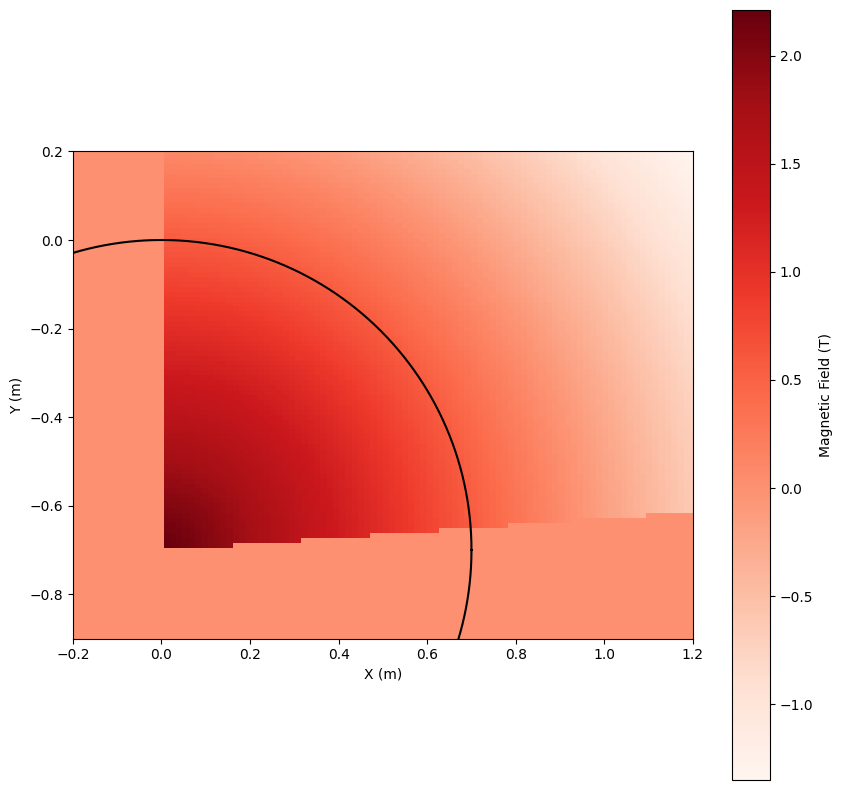

In [156]:

li = [[0.57,2.4]]
A = [1.5]
R = 0.7

default2(A, li, R)



In [66]:
beams = {'Energies': {'file1': [[100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0]], 'file2': [[120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0]], 'file3': [[140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0]]}, 'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file2': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file3': [[-0.2, 0.0], [-0.2, 0.0003497493256804], [-0.2, -0.0006763386816988], [-0.2, 0.0005203743344812], [-0.2, -0.0023851000750595], [-0.2, 0.0003793495454163], [-0.2, -0.0006455781596964], [-0.2, -8.73075635697755e-05], [-0.2, -0.0019387082730754], [-0.2, -0.0004675495886132]]}, 'Directions': {'file1': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file2': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file3': [[1.0, 0.0], [0.999998875000211, -0.0014999994375], [0.999999367187567, -0.0011249997626953], [0.999999718750013, -0.0007499999296875], [0.999999929687501, -0.0003749999912109], [1.0, 0.0], [0.999999929687501, 0.0003749999912109], [0.999999718750013, 0.0007499999296875], [0.999999367187567, 0.0011249997626953], [0.999998875000211, 0.0014999994375]]}}




# Flattening the lists.

energies = [item for sublist in beams['Energies'].values() for item in sublist]
positions = [item for sublist in beams['Positions'].values() for item in sublist]
directions = [item for sublist in beams['Directions'].values() for item in sublist]

#energies = [item for sublist in energies for item in sublist]

print("Energies:", energies)
print("Positions:", (positions))
print("Directions:", (directions))

Energies: [[100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0]]
Positions: [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0003497493256804], [-0.2, -0.0006763386816988], [-0.2, 0.0005203743344812], [-0.2, -0.0023851000750595], [-0.2, 0.0003793495454163], [-0.2, -0.0006455781596964], [-0.2, -8.73075635697755e-05], [-0.2, -0.0019387082730754], [-0.2, -0.0004675495886132]]
Directions: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [

In [ ]:


x,y = get_points(R, A, B, G, [position[0],position[1]], [direction[0],direction[1]], energy, Pages.tracking)  # Plotting the beam
